## Imports

In [76]:
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
from collections import defaultdict
from tqdm import tqdm
import pandas as pd
import random

## Settings

In [77]:
#in_dir = '/home/drevital/obstacles_classification_datasets/rgb_6_balanced'
#out_dir = '/home/drevital/obstacles_classification_datasets/shufersal_sep22_d_2__1_5'
in_dir = '/home/drevital/obstacles_classification_datasets/src_kfs_oct22_a'
out_dir = '/home/drevital/obstacles_classification_datasets/src_kfs_oct22_a/test_dataset_1'
sites_dir = '/home/drevital/obstacles_classification_datasets/rgb_6_balanced/sites'
sites = os.listdir(sites_dir)

# Parameters used in the diff_metric to diff_coef assignent function
alfa = -3.5
beta = 2.0
gamma = 8
swc = 2.0 # sample weight coefficient
diff_threshold = 50
std_threshold_dist = 1.5 # Distance from std to apply sample_weight correction

In [78]:
sites

['kfar_saba',
 'koki_factory',
 'new_factory_humid',
 'musashi_office',
 'shufersal',
 'new_factory',
 'neve_ilan',
 'unknown']

In [79]:
site_thresholds = {'neve_ilan': 55,
                   'kfar_saba': 55,
                   'shufersal': 55,
                   'new_factory': 50,
                   'new_factory_humid': 50,
                   'musashi_office': 40,
                   'koki_factory': 40,
                   'unknown': 50}
default_threshold = 50

## Utility to Plot Image

In [80]:
def plot_image(im, title='', grayscale=False):
    if grayscale:
        plt.imshow(im, cmap='gray', vmin=0, vmax=255)
    else:
        plt.imshow(im)
    plt.title(title)
    plt.show()

## Make dictionary for the image names of each site

In [81]:
site_images = defaultdict(list)

for site in sites:
    site_dir = os.path.join(sites_dir, site)
    site_images[site] = os.listdir(site_dir)

In [82]:
site_images.keys()

dict_keys(['kfar_saba', 'koki_factory', 'new_factory_humid', 'musashi_office', 'shufersal', 'new_factory', 'neve_ilan', 'unknown'])

## A function to find the source site of a given image

In [83]:
def find_site_and_threshold(im_name):
    found_states = [im_name in site_images[site] for site in sites]
    
    if any(found_states):
        site = sites[np.argmax(found_states)]
        threshold = site_thresholds[site]
    else:
        site = 'unknown'
        site_images[site].append(im_name)
        threshold = default_threshold
        
    return site, threshold

## Define curve to assign diff_coef according to diff_metric

In [84]:
def diff_metric_to_diff_coef(sigma_dist):
    
    # Correction curve for assigning coefficients
    # Based on Sigmoid
    # adding alpha, beta and gamma controls, as explained at the
    # beginning of this notebook
    
    return 1/(1 + np.exp(-(sigma_dist*alfa-beta)*gamma))

## Calculate sample_weights

  0%|          | 0/69 [00:00<?, ?it/s]

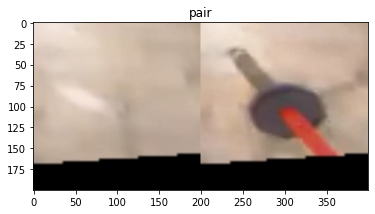

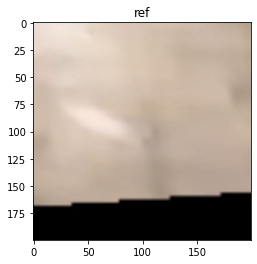

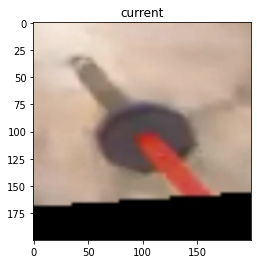

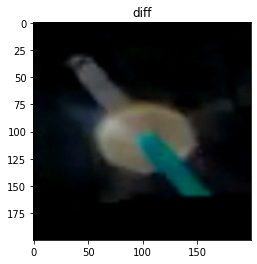

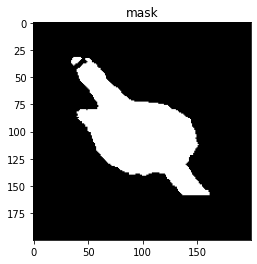

100%|██████████| 63/63 [00:00<00:00, 838.90it/s]

mean: {'no_obstacle': 0.09938007246376812, 'obstacle': 0.11179007936507937}, std: {'no_obstacle': 0.06635906821539192, 'obstacle': 0.07173856976313626}


In [85]:
train_dict = {'in_name': [],
              'out_name': [],
              'class_name': [],
              'diff_metric': [],
              'diff_coef': [],
              'sample_weight': []
             }
diff_metrics = {'no_obstacle': [], 'obstacle': []}
class_names = ['no_obstacle', 'obstacle']
subset_name = 'train'

for class_name in class_names:
    class_path = os.path.join(in_dir, subset_name, class_name)
    im_names = os.listdir(class_path)
    for im_name in tqdm(im_names):
        im_path = os.path.join(class_path, im_name)
        pair = cv2.imread(im_path)
        pair = cv2.cvtColor(pair, cv2.COLOR_BGR2RGB) 

        # Generate diff mask            
        w = pair.shape[1]
        ref = pair[:, :w//2]
        current = pair[:, w//2:(w//2)*2]
        diff = cv2.subtract(ref, current)
        agg_rgb = np.stack((diff[:, :, 0], diff[:, :, 1], diff[:, :, 2])).max(0)
        _, mask = cv2.threshold(agg_rgb, diff_threshold, 255, cv2.THRESH_BINARY)
        
        if im_name == '1806_obstacles_classification_10_2022-10-02T13-19-17_1.jpg':
            plot_image(pair, title='pair')
            plot_image(ref, title='ref')
            plot_image(current, title='current')
            plot_image(diff, title='diff', grayscale=True)
            plot_image(mask, title='mask', grayscale=True)

        # Calculate diff_coeff
        h = mask.shape[0]
        w = mask.shape[1]
        area = h * w

        # Update train dictionary
        train_dict['in_name'].append(im_name)
        train_dict['class_name'].append(class_name)
        diff_metric = (np.sum(mask)/255)/area
        train_dict['diff_metric'].append(diff_metric)    
        diff_metrics[class_name].append(diff_metric)
            
mean = {'no_obstacle': np.mean(diff_metrics['no_obstacle']),
        'obstacle': np.mean(diff_metrics['obstacle'])}
std = {'no_obstacle': np.std(diff_metrics['no_obstacle']),
       'obstacle': np.std(diff_metrics['obstacle']) }
print(f'mean: {mean}, std: {std}')

found_example = False
ind = 0

for i, diff_metric in enumerate(train_dict['diff_metric']):
    class_name = train_dict['class_name'][i]
    # Following is to adjust the direction of distance from std and correction accordingly
    # For obstacle - a negative sigma means we are lower than threshold and need correction
    # For no obstacle a positive sigma means we are higher than threshold and need correction
    sigma_dist_sign = 1.0 if class_name == 'obstacle' else -1.0 
    diff_threshold = mean[class_name] + sigma_dist_sign * std_threshold_dist * std[class_name]
    sigma_dist = sigma_dist_sign * (diff_metric - diff_threshold)/std[class_name]
    if not found_example and class_name == 'obstacle' and (-0.1 < sigma_dist < -0):
        ind = i
        found_example = True
    diff_coef = diff_metric_to_diff_coef(sigma_dist)
    sample_weight = 1.0 + swc * diff_coef
    if i == 11953:
        print(f'diff_metric: {diff_metric}')
        print(f'diff_threshold: {diff_threshold}')
        print(f'sigma_dist: {sigma_dist}')
        print(f'diff_coef: {diff_coef}')
        print(f'sample_weight: {sample_weight}')
    train_dict['diff_coef'].append(diff_coef)
    train_dict['sample_weight'].append(sample_weight)

In [86]:
ind

0

In [23]:
train_dict['in_name'][11953]

'24_729_.02_2022-06-01--15-11-10_.jpg'

In [ ]:
diff_metric_to_diff_coef(-0.57)

## A function to generate <ref, current, mask> triplet from <ref, current> pair

In [ ]:
def triplet_image(pair, threshold):
    w = pair.shape[1]
    ref = pair[:, :w//2]
    current = pair[:, w//2:(w//2)*2]
    diff = cv2.absdiff(current, ref)
    agg_rgb = np.stack((diff[:, :, 0], diff[:, :, 1], diff[:, :, 2])).max(0)
    _, mask = cv2.threshold(agg_rgb, threshold, 255, cv2.THRESH_BINARY)

    # old morphological operations
    copyImg = cv2.erode(mask, np.ones((3, 3), np.uint8), iterations=1)  # reduce noise
    copyImg = cv2.dilate(copyImg, np.ones((7, 7), np.uint8), iterations=1)
    copyImg = cv2.erode(copyImg, np.ones((5, 5), np.uint8), iterations=1)
    copyImg = cv2.dilate(copyImg, np.ones((9, 9), np.uint8), iterations=1)
    kernel = np.ones((11, 11), np.uint8)  # kernel for dilation

    # increase area to an object
    copyImg = cv2.dilate(copyImg, kernel, iterations=2)
    copyImg = cv2.dilate(copyImg, np.ones((13, 13), np.uint8), iterations=1)
    copyImg = cv2.erode(copyImg, np.ones((11, 11), np.uint8), iterations=1)
    copyImg = cv2.erode(copyImg, np.ones((5, 5), np.uint8), iterations=1)

    mask = copyImg 
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)  
    
    return cv2.hconcat([ref, current, mask])

## Generate triplet images <ref, current, mask>

In [ ]:
subset_names = ['train', 'eval']
class_names = ['no_obstacle', 'obstacle']
class_extensions = {'no_obstacle': 'noobs', 'obstacle': 'obs'}

for subset_name in subset_names:
    cur_out_dir = os.path.join(out_dir, subset_name)
    Path(cur_out_dir).mkdir(parents=True, exist_ok=True)

# Prepare indices for shuffling the images in dictionary, so onstacle/no_obstacle are mixed
# This is necessary for the training/validation from corresponding dataframe to work properly

keys = list(train_dict.keys())
shuffled_train_dict = {}
inds = [i for i in range(len(train_dict['in_name']))]
shuffled = inds.copy()
random.shuffle(shuffled)
for k in keys:
    if len(train_dict[k]) > 0:
        shuffled_train_dict[k] = [train_dict[k][shuffled[i]] for i in range(len(train_dict['in_name']))]
    else:
        shuffled_train_dict[k] = []
    
subset_name = 'train'
i = 0
for im_name in tqdm(shuffled_train_dict['in_name']):
    class_name = shuffled_train_dict['class_name'][i]
    class_path = os.path.join(in_dir, subset_name, class_name)
    im_path = os.path.join(class_path, im_name)
    pair = cv2.imread(im_path)
    site, threshold = find_site_and_threshold(im_name)
    triplet = triplet_image(pair, threshold)
    class_extension = class_extensions[class_name]
    sample_weight = shuffled_train_dict['sample_weight'][i]
    out_im_name = '.'.join(im_name.split('.')[:-1])\
         + f'_{site}_{class_extension}_{sample_weight:.4f}_.jpg'
    shuffled_train_dict['out_name'].append(out_im_name)
    cur_out_dir = os.path.join(out_dir, subset_name)
    out_path = os.path.join(cur_out_dir, out_im_name)
    cv2.imwrite(out_path, triplet)
    i += 1
    
subset_name = 'eval'
for class_name in class_names:
    class_path = os.path.join(in_dir, subset_name, class_name)
    im_names = os.listdir(class_path)
    cur_out_dir = os.path.join(out_dir, subset_name, class_name)
    Path(cur_out_dir).mkdir(parents=True, exist_ok=True)
    for im_name in tqdm(im_names):
        im_path = os.path.join(class_path, im_name)
        pair = cv2.imread(im_path)
        site, threshold = find_site_and_threshold(im_name)
        triplet = triplet_image(pair, threshold)
        out_im_name = '.'.join(im_name.split('.')[:-1]) + f'_{site}_.jpg'
        out_path = os.path.join(cur_out_dir, out_im_name)
        cv2.imwrite(out_path, triplet)    

## Create Dataframe from sample_weights Dictionary

In [ ]:
shuffled_train_dict.keys()

In [ ]:
[len(shuffled_train_dict[k]) for k in shuffled_train_dict.keys()]

In [ ]:
train_df = pd.DataFrame.from_dict(shuffled_train_dict)

In [ ]:
train_df

## Store the Dataframe in a .csv file

In [ ]:
csv_name = out_dir.split('/')[-1] + '.csv'
csv_path = os.path.join(out_dir, csv_name)
train_df.to_csv(csv_path)

In [ ]:
mean['obstacle'], std['obstacle']

In [ ]:
mean['no_obstacle'], std['no_obstacle']

In [ ]:
tot = 0
for site in site_images:
    tot += len(site_images[site])
    print(f'{site}: {len(site_images[site])}')
print(f'========== total: {tot}')